In [21]:
\%matplotlib inline

import matplotlib.pyplot as plt

import time
import numpy as np
from numpy import linalg as LA
from numpy.linalg import inv
from pandas import DataFrame
import math
from scipy.optimize import minimize

#Безусловная минимизация невыпуклой функции

<font color='red'>Везде в качестве нормы использовалась норма $L_{\infty}$</font>

####Вычислим первые производные:

$\frac{df}{dx_1}=0.5(x_1-1)+2(2x_1^2-x_2-1)4x_1=16x_1^3-(8x_2+7.5)x_1-0.5$

$\frac{df}{dx_i}|_{n>i>1}=-2(2x_{i-1}^2-x_i-1)+2(2x_i^2-x_{i+1}-1)4x_i=16x_i^3-(8x_{i+1}+6)x_i-2(2x_{i-1}^2-1)$

$\frac{df}{dx_n}=-2(2x_{n-1}^2-x_n-1)=2x_n-4x_{n-1}^2+2$

####Вычислим вторые производные:
    
$\frac{d^2f}{dx_1^2}=48x_1^2-8x_2-7.5$

$\frac{d^2f}{dx_i^2}|_{n>i>1}=48x_i^2-8x_{i+1}-6$

$\frac{d^2f}{dx_n^2}=2$

$\frac{d^2f}{dx_idx_j}|_{|i-j|>1}=0$

$\frac{d^2f}{dx_idx_{i+1}}=-8x_i$

Из первых-вторых производных убеждаемся, что функция невыпуклая

#### Напишем функции расчета первых, вторых производных

In [38]:
def func_1(x):
    result = 0
    result += 0.25*(x[0] - 1)**2
    for i in range(1,len(x)):
        result += (2 * x[i-1]**2 - x[i] - 1)**2
    return result

def grad_1(x):
    size = len(x)
    result = np.zeros(size)
    result[0] = 16 * x[0]**3 - (8 * x[1] + 7.5) * x[0] - 0.5
    result[size-1] = 2 * x[size-1] - 4 * x[size-2]**2 + 2
    for i in range(1,size-1):
        result[i] = 16 * x[i]**3 - (8 * x[i+1] + 6) * x[i] - 2 * (2 * x[i-1]**2 - 1)
    return result

def hess_1(x):
    size = len(x)
    result = np.zeros((size,size))
    for i in range(size):
        for j in range(size):
            if abs(i-j)>1:
                result[i,j] = 0
            elif i == 0 and j == 0:
                result[i,j] = 48 * x[0]**2 - 8 * x[1] - 7.5
            elif i == (size-1) and j == (size-1):
                result[i,j] = 2
            elif i == j:
                result[i,j] = 48 * x[i]**2 - 8 * x[i+1] - 6
            elif i < j:
                result[i,j] = -8 * x[i]
            elif i > j:
                result[i,j] = -8 * x[j]
    return result
def optimize_1d(func_, a, b, epsilon=0.0001, max_iteration = 1000):
    fi = (1.+np.sqrt(5))/2.
    x1 = b - (b-a)/fi
    x2 = a + (b-a)/fi
    iteration = 0
    while ((b-a)/2. > epsilon):
        iteration +=1
        if iteration > max_iteration:
            break
        if func_(x1) > func_(x2):
            a = x1
            x1 = x2
            x2 = b - (x1-a)
        else:
            b = x2
            x2 = x1
            x1 = a + (b-x2)
    return (a+b)/2.
def gen_x0(N):
    result = np.zeros(N)
    for i in range(N):
        if i == 0:
            result[i] = -1.5
        else:
            result[i] = 1
    return result
def x_true_1(N):
    return np.ones(N)

In [16]:
grad_func = grad_1
hess_func = hess_1
func = func_1

In [39]:
class Optimizator:
    def __init__(self, func, grad_func, hess_func, x0, x_true=None):
        self.__func = func
        self.__grad_func = grad_func
        self.__hess_func = hess_func
        self.__x0 = x0
        self.__x_true = x_true
    def optimize(self,method, stop_criteria='norm_grad', epsilon=1e-8, step=None, timelimit=None, max_iterations=None):
        iteration = 0
        time_start = time.time()
        
        x_prev = self.__x0
        self.__steps = [x_prev]
        while(True):
            grad_prev = self.__grad_func(x_prev)
            ####################################################################
            iteration += 1
            if max_iterations != None and iteration >= max_iterations:
                break
                
            if timelimit != None and time.time() - time_start >= timelimit:
                break  
            
            if stop_criteria == 'norm_grad' and LA.norm(grad_prev,np.inf) < epsilon:
                break
            elif stop_criteria == 'norm_grad_n' and LA.norm(grad_prev,np.inf) / len(self.__x0) < epsilon:
                break
            elif stop_criteria == 'norm_func' and abs(self.__func(x_prev) - self.__func(self.__x_true)) < epsilon:
                break
            #####################################################################
            if method == 'gradient':
                x_next = x_prev - step * grad_prev
            elif method == 'steepest_descent':
                step = optimize_1d(lambda x: self.__func(x_prev-x*grad_prev),0, 1, 1e-6)
                x_next = x_prev - step * grad_prev
            elif method == 'conjugate':
                if iteration == 1:
                    s_prev = -grad_prev
                    
                step = optimize_1d(lambda x: self.__func(x_prev + x * s_prev),0, 1, 1e-6)
                x_next = x_prev + step * s_prev
                
                grad_next = self.__grad_func(x_next)  
                w = np.dot(grad_next, grad_next) / np.dot(grad_prev, grad_prev)
                s_next = -grad_next + w * s_prev
                s_prev = s_next
            elif method == 'newton':
                hess_prev = self.__hess_func(x_prev)
                x_next = x_prev - step * np.dot(inv(hess_prev), grad_prev)
            elif method == 'nesterov':
                if iteration == 1:
                    a_prev = 1.
                    eps_prev_prev = 100
                    y_prev = x_prev
                
                a_next = ((4*a_prev**2 + 1)**0.5 + 1) * 0.5
                
                y_prev_grad = self.__grad_func(y_prev)
                eps_prev = eps_prev_prev
                while (True):
                    x_next = y_prev - eps_prev * y_prev_grad
                    if 0.5 * eps_prev * np.dot(y_prev_grad, y_prev_grad) \
                       <= self.__func(y_prev) - self.__func(x_next):
                        break                        
                    eps_prev = eps_prev / 2.
                y_next = x_next + a_prev / a_next * (y_prev - eps_prev * y_prev_grad - x_prev) \
                - (x_next - x_prev) / a_next
            
                y_prev = y_next
                a_prev = a_next
                eps_prev_prev = eps_prev
            x_prev = x_next
            self.__steps.append(x_next)
        self.__steps = np.array(self.__steps)    
        print 'total iterations={}, time={}'.format(iteration, (time.time()-time_start))
    def get_steps(self):
        return self.__steps
    def get_count_iterations(self):
        return len(self.__steps)
    def get_result(self):
        return self.__steps[-1]

In [111]:
optimizator = Optimizator(func, grad_func, hess_func, gen_x0(5))

###Градиентный метод. Произволный выбор шага

In [113]:
optimizator.optimize('gradient', step=0.05, max_iterations=1000)
optimizator.get_result()
steps_grad = optimizator.get_steps()

total iterations=1000, time=0.0522680282593


###Метод наискорейшего спуска

In [115]:
optimizator.optimize('steepest_descent', max_iterations=1000)
optimizator.get_result()
steps_sd = optimizator.get_steps()

total iterations=1000, time=0.933817148209


###Метод сопряженных градиентов

In [116]:
optimizator.optimize('conjugate', max_iterations=1000)
optimizator.get_result()
steps_conj = optimizator.get_steps()

total iterations=1000, time=1.10463118553


###Метод Ньютона

In [117]:
optimizator.optimize('newton', step=0.1, max_iterations=1000)
optimizator.get_result()
steps_newton = optimizator.get_steps()

total iterations=1000, time=0.142575979233


###Метод Нестерова

In [118]:
optimizator.optimize('nesterov', max_iterations=1000)
optimizator.get_result()
steps_nesterov = optimizator.get_steps()

total iterations=1000, time=0.107633829117


##Линии уровня для n=2

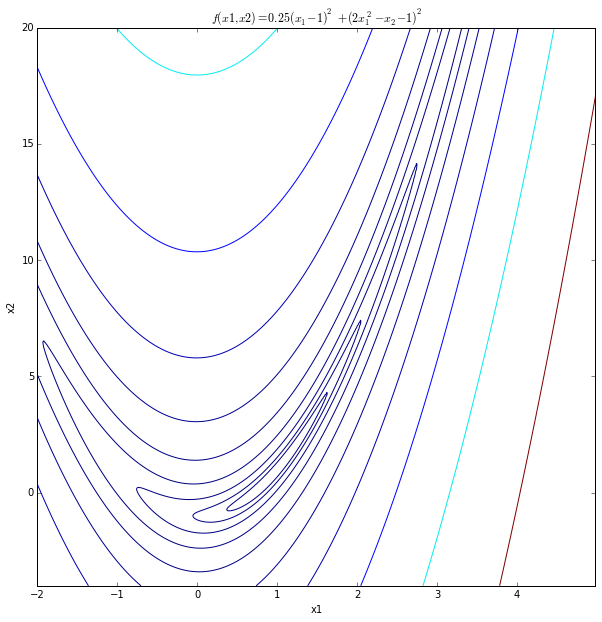

In [8]:
import matplotlib.mlab as mlab
delta = 0.02
x = np.arange(-2.0, 5.0, delta)
y = np.arange(-4.0, 20.0, delta)
X, Y = np.meshgrid(x, y)
Z = func_1([X,Y])


# Create a simple contour plot with labels using default colors.  The
# inline argument to clabel will control whether the labels are draw
# over the line segments of the contour, removing the lines beneath
# the label
levels = np.linspace(-1, 1, 400)
plt.figure(figsize=(10,10))
plt.contour(X, Y, Z, levels=np.logspace(-1,3,10))
plt.title("$f(x1,x2)=0.25(x_1-1)^2+(2x_1^2-x_2-1)^2$")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

####Построим теперь кривые спуска для каждого из рассмотренных методов

In [9]:
def plotSteps(sub, steps, description):
    sub.contour(X, Y, Z, levels=np.logspace(-1,3,10))
    sub.set_xlabel("x1")
    sub.set_ylabel("x2")
    sub.set_title(description)
    sub.plot(steps[:,0],steps[:,1], marker='.', color='black')

In [90]:
optimizator_2d = Optimizator(func, grad_func, hess_func, gen_x0(2))

####Градиентный метод

total iterations=1000, time=0.044939994812
total iterations=1000, time=0.0235149860382
total iterations=1000, time=0.0237240791321


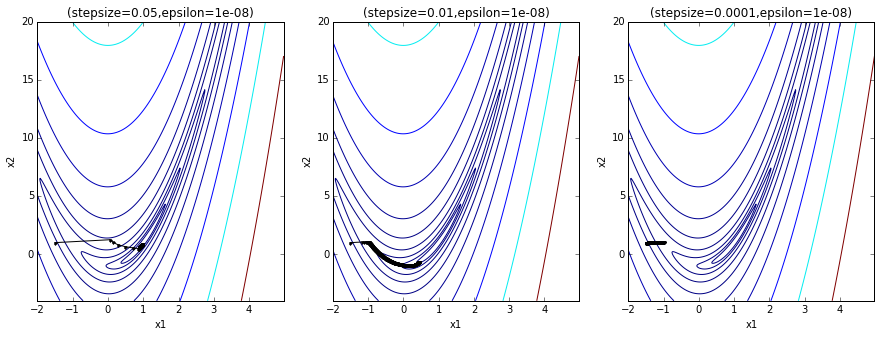

In [63]:
plt.figure(figsize=(15, 5))
sub = plt.subplot(1, 3, 1)
step = 0.05
optimizator_2d.optimize('gradient', step=step, max_iterations=1000)
plotSteps(sub, optimizator_2d.get_steps(), '(stepsize={},epsilon={})'.format(step,epsilon))
sub = plt.subplot(1, 3, 2)
step=0.01
optimizator_2d.optimize('gradient', step=step, max_iterations=1000)
plotSteps(sub, optimizator_2d.get_steps(), '(stepsize={},epsilon={})'.format(step,epsilon))
sub = plt.subplot(1, 3, 3)
step=0.0001
optimizator_2d.optimize('gradient', step=step, max_iterations=1000)
plotSteps(sub, optimizator_2d.get_steps(), '(stepsize={},epsilon={})'.format(step,epsilon))
plt.show()

<font color='red'>На изображениях видно, что скорость сходимости градиентного метода сильно зависит от выбора шага. При этом в случае неудачно выбранного шага метод может расходится, или сходится чересчур медленно(см. 3 изображение)</font>

###Метод наискорейшего спуска

total iterations=66, time=0.0392129421234
total iterations=1000, time=0.513175964355
total iterations=1000, time=0.567755937576


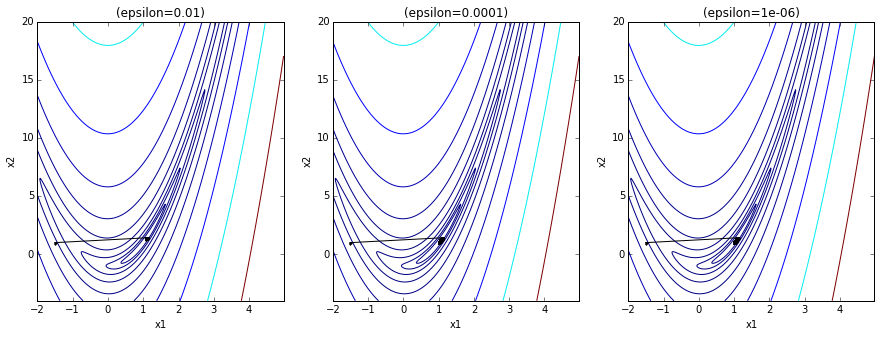

In [65]:
plt.figure(figsize=(15, 5))
sub = plt.subplot(1, 3, 1)
epsilon = 1e-2
optimizator_2d.optimize('steepest_descent', epsilon=epsilon, max_iterations=1000)
plotSteps(sub, optimizator_2d.get_steps(), '(epsilon={})'.format(epsilon))
sub = plt.subplot(1, 3, 2)
epsilon = 1e-4
optimizator_2d.optimize('steepest_descent', epsilon=epsilon, max_iterations=1000)
plotSteps(sub, optimizator_2d.get_steps(), '(epsilon={})'.format(epsilon))
sub = plt.subplot(1, 3, 3)
epsilon = 1e-6
optimizator_2d.optimize('steepest_descent', epsilon=epsilon, max_iterations=1000)
plotSteps(sub, optimizator_2d.get_steps(), '(epsilon={})'.format(epsilon))
plt.show()

<font color='red'>В сравнении с градиентным методом, метод наиск. спуска практически сходится за пару итераций. На данных изображениях видно, что скорость сходимости зависит от критерия остановки($\epsilon$)</font>

###Метод сопряженного градиента

total iterations=11, time=0.005784034729
total iterations=24, time=0.0124039649963
total iterations=42, time=0.0219178199768


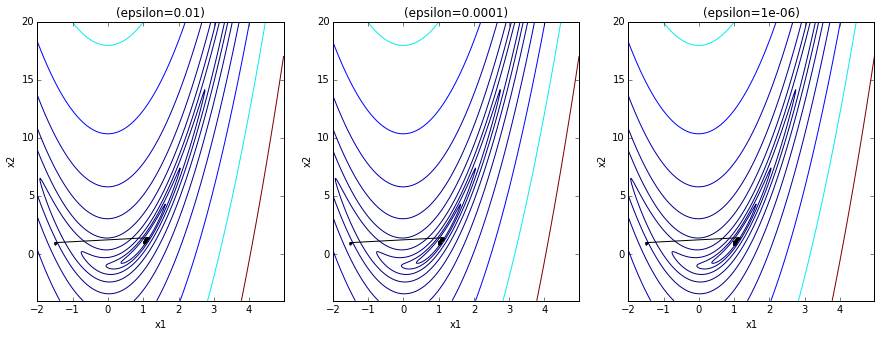

In [68]:
plt.figure(figsize=(15, 5))
sub = plt.subplot(1, 3, 1)
epsilon = 1e-2
optimizator_2d.optimize('conjugate', epsilon=epsilon, max_iterations=1000)
plotSteps(sub, optimizator_2d.get_steps(), '(epsilon={})'.format(epsilon))
sub = plt.subplot(1, 3, 2)
epsilon = 1e-4
optimizator_2d.optimize('conjugate', epsilon=epsilon, max_iterations=1000)
plotSteps(sub, optimizator_2d.get_steps(), '(epsilon={})'.format(epsilon))
sub = plt.subplot(1, 3, 3)
epsilon = 1e-6
optimizator_2d.optimize('conjugate', epsilon=epsilon, max_iterations=1000)
plotSteps(sub, optimizator_2d.get_steps(), '(epsilon={})'.format(epsilon))
plt.show()

<font color='red'>Реализация метода сопр. градиента для произвольной функции близка к методу наиск. спуска. В данном случае лишь добавляется некая "инерционность" от предыдущих шагов. На изображениях видим что сходится данный метод быстрее метода Наиск. спуска. Однако в разных случаях, как мы увидим ниже, возможно обратное</font>

###Метод Ньютона

total iterations=7, time=0.000550031661987
total iterations=221, time=0.0140719413757
total iterations=1000, time=0.0629479885101


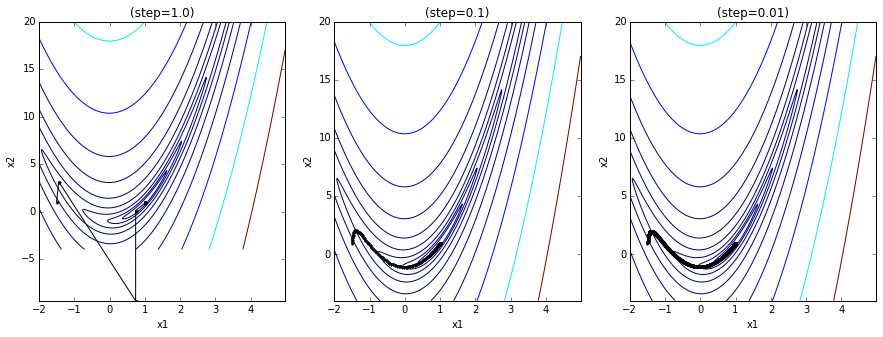

In [69]:
plt.figure(figsize=(15, 5))
sub = plt.subplot(1, 3, 1)
epsilon = 1e-8
step=1.
optimizator_2d.optimize('newton', step=step, epsilon=epsilon, max_iterations=1000)
plotSteps(sub, optimizator_2d.get_steps(), '(step={})'.format(step,epsilon))
sub = plt.subplot(1, 3, 2)
step=0.1
optimizator_2d.optimize('newton', step=step, epsilon=epsilon, max_iterations=1000)
plotSteps(sub, optimizator_2d.get_steps(), '(step={})'.format(step,epsilon))
sub = plt.subplot(1, 3, 3)
step=0.01
optimizator_2d.optimize('newton', step=step, epsilon=epsilon, max_iterations=1000)
plotSteps(sub, optimizator_2d.get_steps(), '(step={})'.format(step,epsilon))
plt.show()

<font color='red'>Из исследований данного метода выяснилось, что рекомендуется добавлять в метод параметр шага, иначе метод может расходится. на изображении 1 видим реализацию чистого метода Ньютона без шага. Видим, что метод ведет себя довольно непредсказуемо. При выборе удачного шага метод близок к методу градиент. спуска. Явный недостаток метода заключается в том, что на больших размероностях гессиан (который при этом нужно вычислять) может быть плохо обусловлен и не обращается, таким образом метод перестает работать.</font>

###Метод Нестерова

total iterations=140, time=0.0104579925537
total iterations=500, time=0.0285429954529
total iterations=1000, time=0.0568108558655


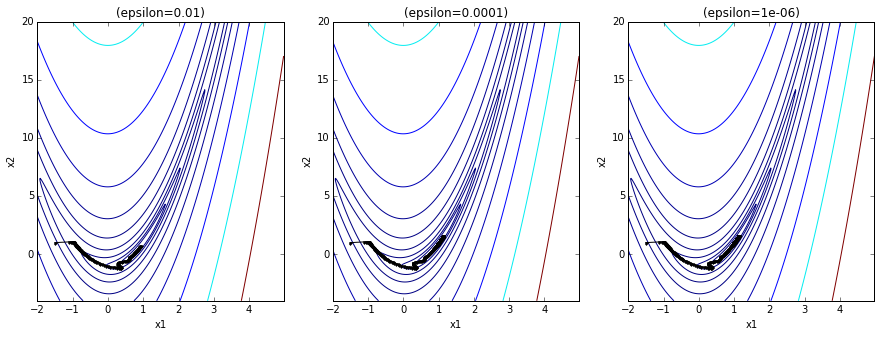

In [91]:
plt.figure(figsize=(15, 5))
sub = plt.subplot(1, 3, 1)
epsilon = 1e-2
optimizator_2d.optimize('nesterov', epsilon=epsilon, max_iterations=1000)
plotSteps(sub, optimizator_2d.get_steps(), '(epsilon={})'.format(epsilon))
sub = plt.subplot(1, 3, 2)
epsilon = 1e-4
optimizator_2d.optimize('nesterov', epsilon=epsilon, max_iterations=1000)
plotSteps(sub, optimizator_2d.get_steps(), '(epsilon={})'.format(epsilon))
sub = plt.subplot(1, 3, 3)
epsilon = 1e-6
optimizator_2d.optimize('nesterov', epsilon=epsilon, max_iterations=1000)
plotSteps(sub, optimizator_2d.get_steps(), '(epsilon={})'.format(epsilon))
plt.show()

##Сходимость

In [103]:
result_gradient = []
for n in np.logspace(0.4,3,8, dtype='int'):
    opt_n = Optimizator(func, grad_func, hess_func, gen_x0(n))
    
    opt_n.optimize('gradient', step=0.05, timelimit=300)
    x_res=opt_n.get_result()
    result_gradient.append(['gradient', n, opt_n.get_count_iterations(), 
                   LA.norm(grad_func(x_res),np.inf), LA.norm(x_true_1(n)- x_res), 
                   abs(func(x_true_1(n))- func(x_res)), np.all(np.isclose(x_true_1(n),x_res, 1e-2))])

total iterations=9674, time=0.302598953247
total iterations=6446516, time=303.543599129
total iterations=4277649, time=302.417708874
total iterations=2221397, time=301.638318777
total iterations=1053594, time=302.110203981
total iterations=474121, time=300.993940115
total iterations=206209, time=300.80170393
total iterations=87107, time=300.635900021


In [105]:
result_sd = []
for n in np.logspace(0.4,3,8, dtype='int'):
    opt_n = Optimizator(func, grad_func, hess_func, gen_x0(n))
    
    opt_n.optimize('steepest_descent', timelimit=300)
    x_res=opt_n.get_result()
    result_sd.append(['steepest_descent', n, opt_n.get_count_iterations(), 
                   LA.norm(grad_func(x_res),np.inf), LA.norm(x_true_1(n)- x_res), 
                   abs(func(x_true_1(n))- func(x_res)), np.all(np.isclose(x_true_1(n),x_res, 1e-2))])    

total iterations=4416, time=2.41562891006
total iterations=348464, time=300.169689894
total iterations=26, time=0.0436198711395
total iterations=26, time=0.0825839042664
total iterations=26, time=0.182517051697
total iterations=26, time=0.425806045532
total iterations=26, time=1.06133890152
total iterations=26, time=2.35648417473


In [106]:
result_c = []
for n in np.logspace(0.4,3,8, dtype='int'):
    opt_n = Optimizator(func, grad_func, hess_func, gen_x0(n))
    
    opt_n.optimize('conjugate', timelimit=300)
    x_res=opt_n.get_result()
    result_c.append(['conjugate', n, opt_n.get_count_iterations(), 
                   LA.norm(grad_func(x_res),np.inf), LA.norm(x_true_1(n)- x_res), 
                   abs(func(x_true_1(n))- func(x_res)), np.all(np.isclose(x_true_1(n),x_res, 1e-2))])

total iterations=60, time=0.0432229042053
total iterations=301199, time=300.196408033
total iterations=177360, time=300.098345995
total iterations=76719, time=300.041957855
total iterations=40742, time=300.029013157
total iterations=16751, time=300.028218031
total iterations=6937, time=300.059227943
total iterations=3058, time=300.068557024


In [108]:
result_newton = []
for n in np.logspace(0.4,3,8, dtype='int'):
    opt_n = Optimizator(func, grad_func, hess_func, gen_x0(n))
    
    opt_n.optimize('newton', step=0.2, timelimit=300)
    x_res=opt_n.get_result()
    result_newton.append(['newton', n, opt_n.get_count_iterations(), 
                   LA.norm(grad_func(x_res),np.inf), LA.norm(x_true_1(n)- x_res), 
                   abs(func(x_true_1(n))- func(x_res)), np.all(np.isclose(x_true_1(n),x_res, 1e-2))])

total iterations=114, time=0.0157830715179
total iterations=1215, time=0.176339149475
total iterations=1233119, time=300.647169113


LinAlgError: Singular matrix

In [109]:
result_nesterov = []
for n in np.logspace(0.4,3,8, dtype='int'):
    opt_n = Optimizator(func, grad_func, hess_func, gen_x0(n))
    
    opt_n.optimize('nesterov', step=0.1, timelimit=300)
    x_res=opt_n.get_result()
    result_nesterov.append(['nesterov', n, opt_n.get_count_iterations(), 
                   LA.norm(grad_func(x_res),np.inf), LA.norm(x_true_1(n)- x_res), 
                   abs(func(x_true_1(n))- func(x_res)), np.all(np.isclose(x_true_1(n),x_res, 1e-2))])

total iterations=10687, time=0.884418964386
total iterations=51637, time=5.8478178978
total iterations=1685293, time=300.88500905
total iterations=828069, time=300.681511879
total iterations=381661, time=300.32593298
total iterations=179946, time=300.219666958
total iterations=76598, time=300.13974309
total iterations=34272, time=300.118837118


In [110]:
df = DataFrame(result_gradient+result_sd+result_c+result_newton+result_nesterov, columns=['Метод','n', 'N', '$||grad f(x\')||$','$||x^* - x\'||$', '$|f^* - f(x\')|$', 'Сошелся?'])
df

,Метод,n,N,$||grad f(x')||$,$||x^* - x'||$,$|f^* - f(x')|$,Сошелся?
0,gradient,2,9674,9.985821e-09,3.545143e-07,1.822988e-15,True
1,gradient,5,6446516,2.462305e-01,2.188763e+00,1.584599e-03,False
2,gradient,13,4277649,6.626776e+00,3.698908e+00,1.511535e+00,False
3,gradient,32,2221397,1.027219e+01,3.804144e+00,1.442518e+01,False
4,gradient,76,1053594,1.028015e+01,4.071310e+00,4.079723e+01,False
5,gradient,180,474121,1.133839e+01,4.567963e+00,1.305351e+02,False
6,gradient,425,206209,1.125048e+01,5.394310e+00,2.701364e+02,False
7,gradient,1000,87107,1.129870e+01,7.278420e+00,6.618817e+02,False
8,steepest_descent,2,4416,9.994942e-09,3.212542e-07,1.497200e-15,True
9,steepest_descent,5,348464,2.394603e-08,3.647346e-03,4.674375e-11,True


<font color='red'>Из данной таблицы видим что на различных размерностях лучше всего себя повел метод наиск. спуска. Возможно не последее место здесь сыграла его простота</font>

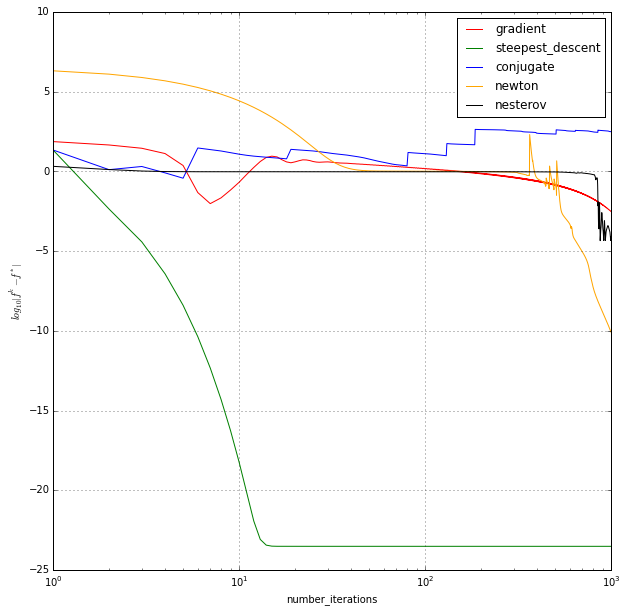

In [136]:
plt.figure(figsize=(10,10))
plt.ylabel("$log_{10}|f^k-f^*|$")
plt.xlabel("number_iterations")
#plt.ylim(0.0, 1.1)
plt.grid()
plt.plot(range(len(steps_grad)), [np.log(np.abs(func(x)-func(x_true_1(5)))) for x in steps_grad], '-', color="r", label="gradient")
plt.plot(range(len(steps_sd)), [np.log(np.abs(func(x)-func(x_true_1(5)))) for x in steps_sd], '-', color="g", label="steepest_descent")
plt.plot(range(len(steps_conj)), [np.log(np.abs(func(x)-func(x_true_1(5)))) for x in steps_conj], '-', color="b", label="conjugate")
plt.plot(range(len(steps_newton)), [np.log(np.abs(func(x)-func(x_true_1(5)))) for x in steps_newton], '-', color="orange", label="newton")
plt.plot(range(len(steps_nesterov)), [np.log(np.abs(func(x)-func(x_true_1(5)))) for x in steps_nesterov], '-', color="black", label="nesterov")
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc="best")
plt.show()

<font color='red'>На изображении выше мы построили график для n=5. Видим, что метод Нестерова практически сразу сходится. Лучше всего себя ведет метод Наиск. спуска. Метод сопр. градиентов, напротив, ведет себя хуже всех и единственный не сходится</font>

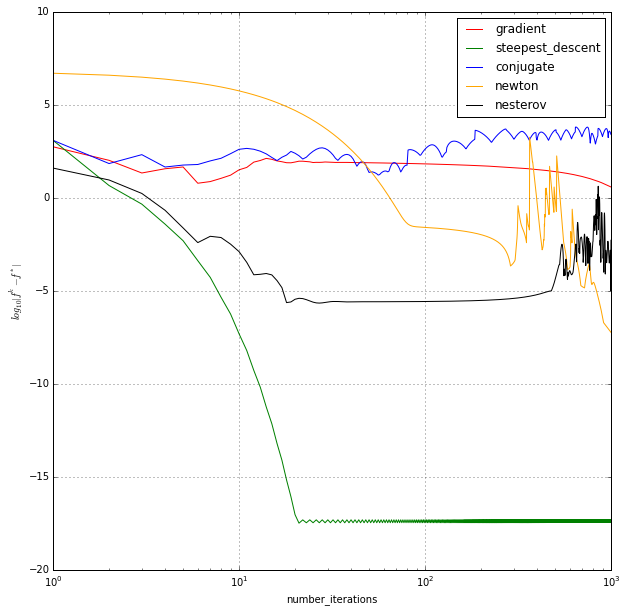

In [139]:
plt.figure(figsize=(10,10))
plt.ylabel("$log_{10}|f^k-f^*|$")
plt.xlabel("number_iterations")
#plt.ylim(0.0, 1.1)
plt.grid()
plt.plot(range(len(steps_grad)), [np.log(LA.norm(grad_func(x)-grad_func(x_true_1(5)),np.inf)) for x in steps_grad], '-', color="r", label="gradient")
plt.plot(range(len(steps_sd)), [np.log(LA.norm(grad_func(x)-grad_func(x_true_1(5)),np.inf)) for x in steps_sd], '-', color="g", label="steepest_descent")
plt.plot(range(len(steps_conj)), [np.log(LA.norm(grad_func(x)-grad_func(x_true_1(5)),np.inf)) for x in steps_conj], '-', color="b", label="conjugate")
plt.plot(range(len(steps_newton)), [np.log(LA.norm(grad_func(x)-grad_func(x_true_1(5)),np.inf)) for x in steps_newton], '-', color="orange", label="newton")
plt.plot(range(len(steps_nesterov)), [np.log(LA.norm(grad_func(x)-grad_func(x_true_1(5)),np.inf)) for x in steps_nesterov], '-', color="black", label="nesterov")
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc="best")
plt.show()

<font color='red'>изображение выше отображает поведеие уже модуля производных для того же случая. Здесь можно попытаться понять, почему тот или иной метод себя ведет по разному. Нам же интересен метод сопр. градиента. Видим что производная не сходится к нулю. Возможно это связано с тем, что "инерционность" аккумулирует сумму всех предыдущих производных</font>

#Безусловная минимизация выпуклой функции

$f(x)=\sum \limits_{i=1}^{n} e^{-x_i} + e^{\sum \limits_{i=1}^{n} x_i - 1}$

####Вычислим первые производные:

$\frac{df}{dx_i}=-e^{-x_i}+e^{\sum \limits_{i=1}^{n} x_i - 1}$


####Вычислим вторые производные:

$\frac{d^2f}{dx_i^2}=e^{-x_i}+e^{\sum \limits_{i=1}^{n} x_i - 1}$

$\frac{d^2f}{dx_idx_j}|_{i\neq j}=e^{\sum \limits_{i=1}^{n} x_i - 1}$

In [12]:
def func_2(x):
    return np.sum(np.exp(-x))+np.exp(np.sum(x)-1)

def grad_2(x):
    size = len(x)
    sum_x = np.sum(x)
    result = np.zeros(size)
    for i in range(size):
        result[i] = -math.exp(-x[i]) + math.exp(sum_x-1)
    return result

def hess_2(x):
    size = len(x)
    result = np.zeros((size,size))
    sum_x=np.sum(x)
    for i in range(size):
        for j in range(size):
            result[i,j] = math.exp(sum_x-1)
            if i == j:
                result[i,j] += - math.exp(-x[i])
    return result

def func_2_dirty(P, x):
    return np.sum(np.exp(-np.dot(P,x)))+np.exp(np.sum(np.dot(P,x))-1)
def grad_2_dirty(P, x):
    return -np.dot(np.transpose(P) ,np.exp(-np.dot(P, x))) + np.exp(np.dot(np.sum(P, axis=0), x) - 1)*np.sum(P,axis=0)

In [126]:
def GenerateP(n_dimension):
    d = np.logspace(-6,0,n_dimension)
    D = np.diag(d)
    return D

In [127]:
x0 = np.random.rand(100)/10-0.5

In [128]:
P = GenerateP(100)
func2 = func_2
func2dirty = lambda x: func_2_dirty(P, x)
grad2 = grad_2
grad2dirty = lambda x: grad_2_dirty(P, x)

#### Найдем минимум стандартным решателем

In [129]:
res = minimize(func_2, x0,
                options={'xtol': 1e-8, 'disp': True})
x_true_def = res.x
print x_true_def

Optimization terminated successfully.
         Current function value: 100.004934
         Iterations: 8
         Function evaluations: 1632
         Gradient evaluations: 16
[ 0.0099008   0.00990046  0.00990148  0.00990056  0.00990061  0.00990156
  0.00990133  0.00990106  0.00990148  0.00990028  0.00990128  0.00990097
  0.00990045  0.00990112  0.00990119  0.00990132  0.00990076  0.00990083
  0.00990085  0.00990097  0.00990093  0.00990119  0.00990133  0.00990092
  0.00990063  0.0099005   0.00990163  0.00990105  0.00990078  0.00990151
  0.0099005   0.00990148  0.00990073  0.00990033  0.00990108  0.00990091
  0.00990111  0.00990168  0.00990167  0.00990076  0.00990133  0.00990077
  0.00990057  0.00990148  0.00990087  0.00990031  0.00990114  0.00990131
  0.00990143  0.00990061  0.00990052  0.00990099  0.00990056  0.00990142
  0.00990098  0.00990153  0.0099003   0.00990062  0.00990067  0.00990066
  0.00990087  0.00990107  0.00990098  0.0099009   0.00990139  0.00990103
  0.00990115  0.009900

/home/necnec/progs/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: OptimizeWarning: Unknown solver options: xtol
  from IPython.kernel.zmq import kernelapp as app


In [135]:
res = minimize(func2dirty, x0, method = 'Nelder-Mead',
                options={'xtol': 1e-8, 'disp': True})
x_true_def_dirty = res.x
print x_true_def_dirty

[ -1.00242721e+00   9.40567508e-01   8.74850604e-02  -9.52749246e-01
  -7.44868395e-01  -1.57804188e+00   1.97693344e+00   1.05310355e+00
  -1.00200505e+00  -1.45902391e+00  -1.57233028e+00   9.94917905e-01
  -1.72698620e+00  -1.50164221e+00  -3.26357359e+00  -2.69596688e+00
  -1.20196543e+00   1.29026214e+00  -1.60645304e+00  -1.75264542e+00
  -7.43951059e-01   8.21585058e-01   2.69035061e+00  -9.44430167e-01
   3.32979232e-01  -1.48951021e-01  -1.51564113e+00  -1.47605851e+00
   2.26147366e-03  -1.69054941e+00  -6.53547017e-01   1.14962392e+00
  -7.55487521e-01  -1.17787337e+00  -6.92661229e-01  -1.17687139e-01
  -4.49224120e+00  -1.16075261e+00  -1.07330918e+00  -5.60866466e-01
  -6.72915654e-01  -3.47997994e-01  -3.98155641e-02  -1.84046715e+00
  -8.23450381e-01  -1.36705324e-01  -4.02302388e-01  -2.03823411e+00
  -1.18358977e+00  -1.59674472e+00  -2.46293737e-01   7.03662083e-01
  -7.13658041e-01  -2.94713566e-01  -1.52958693e+00   4.69511336e-02
   4.64233177e-02   3.53545935e-01

#### Сравним с нашими моделями

In [136]:
opt2 = Optimizator(func2, grad2, None, x0, x_true_def)
opt2dirty = Optimizator(func2dirty, grad2dirty, None, x0, x_true_def_dirty)

In [137]:
opt2.optimize('steepest_descent', stop_criteria='norm_grad_n', epsilon=1e-8, timelimit=300)
x_res=opt2.get_result()
sd_norm_grad = ['steepest_descent(gradient stop)', opt2.get_count_iterations(), 
               LA.norm(grad2(x_res),np.inf), LA.norm(x_true_def - x_res), 
               abs(func2(x_true_def)- func2(x_res)), None]  
steps_sd_norm_grad = opt2.get_steps()


opt2.optimize('steepest_descent', stop_criteria='norm_func', epsilon=1e-6, timelimit=300)
x_res=opt2.get_result()
sd_norm_func = ['steepest_descent(func stop)', opt2.get_count_iterations(), 
               LA.norm(grad2(x_res),np.inf), LA.norm(x_true_def- x_res), 
               abs(func2(x_true_def)- func2(x_res)), None]
steps_sd_norm_func = opt2.get_steps() 


opt2.optimize('nesterov', stop_criteria='norm_grad_n', epsilon=1e-8, timelimit=300)
x_res=opt2.get_result()
nest_norm_grad = ['nesterov(gradient stop)', opt2.get_count_iterations(), 
               LA.norm(grad2(x_res),np.inf), LA.norm(x_true_def - x_res), 
               abs(func2(x_true_def)- func2(x_res)), None]  
steps_nest_norm_grad = opt2.get_steps()


opt2.optimize('nesterov', stop_criteria='norm_func', epsilon=1e-6, timelimit=300)
x_res=opt2.get_result()
nest_norm_func = ['nesterov(func stop)', opt2.get_count_iterations(), 
               LA.norm(grad2(x_res),np.inf), LA.norm(x_true_def- x_res), 
               abs(func2(x_true_def)- func2(x_res)), None]
steps_nest_norm_func = opt2.get_steps() 


total iterations=10, time=0.0194489955902
total iterations=6, time=0.0110249519348
total iterations=1379, time=0.596065998077
total iterations=97, time=0.0431680679321


In [144]:

###################################################################################

opt2dirty.optimize('steepest_descent', stop_criteria='norm_grad_n', epsilon=1e-8, timelimit=300)
x_res=opt2dirty.get_result()
sd_norm_grad_dirty = ['steepest_descent(gradient stop)', opt2dirty.get_count_iterations(), 
               LA.norm(grad2dirty(x_res),np.inf), LA.norm(x_true_def_dirty - x_res), 
               abs(func2dirty(x_true_def_dirty)- func2dirty(x_res)), None]  
steps_sd_norm_grad_dirty = opt2dirty.get_steps()


opt2dirty.optimize('steepest_descent', stop_criteria='norm_func', epsilon=1e-6, timelimit=300)
x_res=opt2dirty.get_result()
sd_norm_func_dirty = ['steepest_descent(func stop)', opt2dirty.get_count_iterations(), 
               LA.norm(grad2dirty(x_res),np.inf), LA.norm(x_true_def_dirty- x_res), 
               abs(func2dirty(x_true_def_dirty)- func2dirty(x_res)), None]
steps_sd_norm_func_dirty = opt2dirty.get_steps() 


total iterations=96368, time=300.087599039
total iterations=96107, time=300.093518019


In [146]:

opt2dirty.optimize('nesterov', stop_criteria='norm_grad_n', epsilon=1e-8, timelimit=300)
x_res=opt2dirty.get_result()
nest_norm_grad_dirty = ['nesterov(gradient stop)', opt2dirty.get_count_iterations(), 
               LA.norm(grad2dirty(x_res),np.inf), LA.norm(x_true_def_dirty - x_res), 
               abs(func2dirty(x_true_def_dirty)- func2dirty(x_res)), None]  
steps_nest_norm_grad_dirty = opt2.get_steps()


opt2dirty.optimize('nesterov', stop_criteria='norm_func', epsilon=1e-6, timelimit=300)
x_res=opt2dirty.get_result()
nest_norm_func_dirty = ['nesterov(func stop)', opt2dirty.get_count_iterations(), 
               LA.norm(grad2dirty(x_res),np.inf), LA.norm(x_true_def_dirty- x_res), 
               abs(func2dirty(x_true_def_dirty)- func2dirty(x_res)), None]
steps_nest_norm_func_dirty = opt2dirty.get_steps()

total iterations=37170, time=16.8667309284
total iterations=517306, time=301.01111412


In [147]:
df = DataFrame([sd_norm_grad,sd_norm_func,nest_norm_grad,nest_norm_func,
               sd_norm_grad_dirty,sd_norm_func_dirty,nest_norm_grad_dirty,nest_norm_func_dirty], 
               columns=['Метод', 'N', '$||grad f(x\')||$','$||x^* - x\'||$', '$|f^* - f(x\')|$', 'Скорость сходимости'])
df

,Метод,N,$||grad f(x')||$,$||x^* - x'||$,$|f^* - f(x')|$,Скорость сходимости
0,steepest_descent(gradient stop),10,8.213606e-07,0.000006,4.504841e-12,None
1,steepest_descent(func stop),6,1.787821e-04,0.000951,4.478236e-07,None
2,nesterov(gradient stop),1379,4.829861e-07,0.000004,5.528022e-12,None
3,nesterov(func stop),97,1.702497e-04,0.000768,2.919644e-07,None
4,steepest_descent(gradient stop),96368,4.007038e-05,19.362832,2.122190e-02,None
5,steepest_descent(func stop),96107,1.271733e-04,19.349824,2.121939e-02,None
6,nesterov(gradient stop),37170,9.999801e-07,226.772340,2.493577e-02,None
7,nesterov(func stop),517306,4.036475e-06,1084.723037,2.593116e-02,None


<font color='red'>В данной таблице строки 0-3 - для чистой функции, а 4-7 для испорченной. Стоит обратить внимание, что для плохо обусловленных задач (испорченная фунция) сходимость методов в разы уменьшается, что мы собственно здесь и увидели.</font>

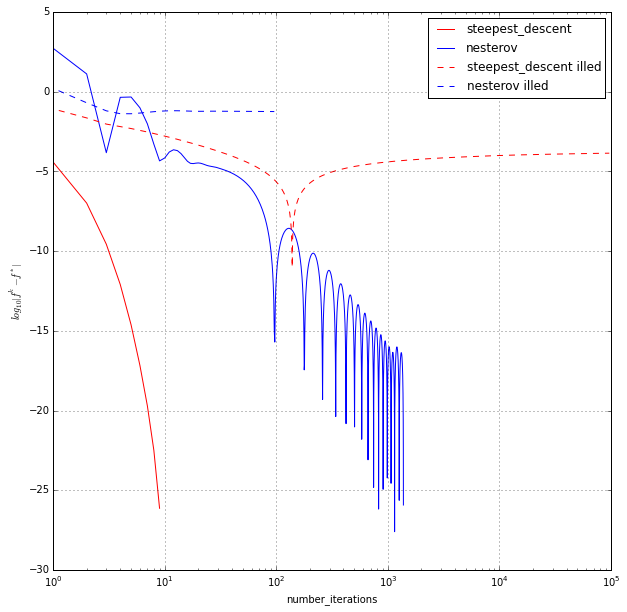

In [149]:
plt.figure(figsize=(10,10))
plt.ylabel("$log_{10}|f^k-f^*|$")
plt.xlabel("number_iterations")
#plt.ylim(0.0, 1.1)
plt.grid()
plt.plot(range(len(steps_sd_norm_grad)), [np.log(np.abs(func2(x)-func2(x_true_def))) for x in steps_sd_norm_grad], '-', color="r", label="steepest_descent")
plt.plot(range(len(steps_nest_norm_grad)), [np.log(np.abs(func2(x)-func2(x_true_def))) for x in steps_nest_norm_grad], '-', color="b", label="nesterov")
plt.plot(range(len(steps_sd_norm_grad_dirty)), [np.log(np.abs(func2dirty(x)-func2dirty(x_true_def_dirty))) for x in steps_sd_norm_grad_dirty], '--', color="r", label="steepest_descent illed")
plt.plot(range(len(steps_nest_norm_grad_dirty)), [np.log(np.abs(func2dirty(x)-func2dirty(x_true_def_dirty))) for x in steps_nest_norm_grad_dirty], '--', color="b", label="nesterov illed")
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc="best")
plt.show()